In [17]:
"""
Caleb Ellington
ML 10701, Fall 2020
Final Project

CNN Baseline
"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
import time

# AWS
import sagemaker
import s3fs

In [18]:
# load data from s3
role = sagemaker.get_execution_role()
fs = s3fs.S3FileSystem()
bucket = 'cellingt-ml-final-project'

dataset = np.load(fs.open('s3://cellingt-ml-final-project/data/FER/FER_old.npz'))
xtrain, xtest, xvalid, ytrain, ytest, yvalid, labels = dataset['xtrain'], dataset['xtest'], dataset['xvalid'], dataset['ytrain'], dataset['ytest'], dataset['yvalid'], dataset['labels']
ylabels = {i:label for i, label in enumerate(labels)}

In [19]:
xtrain = xtrain[:,:,:,np.newaxis]
xtest = xtest[:,:,:,np.newaxis]
xvalid = xvalid[:,:,:,np.newaxis]

Text(0, 0.5, 'Percentage')

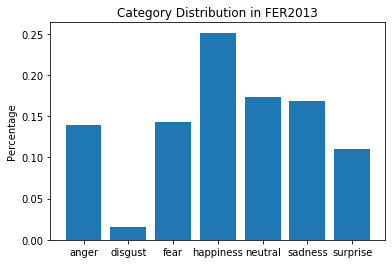

In [20]:
ytrain_labels = np.array([ylabels[np.argmax(yval)] for yval in ytrain])
counts = []
for val in np.unique(ytrain_labels):
    counts.append(np.sum(ytrain_labels == val).astype(int) / len(ytrain_labels))

plt.bar(np.unique(ytrain_labels), counts)
plt.title("Category Distribution in FER2013")
plt.ylabel("Percentage")

fear


(-0.5, 47.5, 47.5, -0.5)

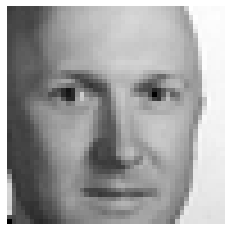

In [49]:
i = 33
print(ylabels[np.argmax(ytrain[i])])
plt.imshow(xtrain[i,:,:,0], cmap='gray')
plt.axis('off')

In [21]:
# Build default TF2 CNN
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(labels), activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)         

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xtest, ytest))
model.save_weights(f's3://cellingt-ml-final-project/models/CNN_FER_baseline_dropout_epoch{epochs}_{int(time.time())}.ckpt')

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 68s 2ms/sample - loss: 2.1067 - accuracy: 0.2664 - val_loss: 1.6658 - val_accuracy: 0.3675
Epoch 2/10
28709/28709 [==============================] - 67s 2ms/sample - loss: 1.6306 - accuracy: 0.3654 - val_loss: 1.5018 - val_accuracy: 0.4157
Epoch 3/10
28709/28709 [==============================] - 66s 2ms/sample - loss: 1.4918 - accuracy: 0.4244 - val_loss: 1.4032 - val_accuracy: 0.4617
Epoch 4/10
28709/28709 [==============================] - 67s 2ms/sample - loss: 1.4066 - accuracy: 0.4558 - val_loss: 1.3649 - val_accuracy: 0.4684
Epoch 5/10
28709/28709 [==============================] - 96s 3ms/sample - loss: 1.3423 - accuracy: 0.4820 - val_loss: 1.3124 - val_accuracy: 0.4948
Epoch 6/10
28709/28709 [==============================] - 197s 7ms/sample - loss: 1.3005 - accuracy: 0.5015 - val_loss: 1.3123 - val_accuracy: 0.4907
Epoch 7/10
28709/28709 [==============================] 

In [27]:
# Confusion matrix calculation
yvalid_pred = model.predict(xvalid.astype(float))
yvalid_pred.shape

(3589, 10)

In [37]:
yvalid_label = np.array([ylabels[np.argmax(yval)] for yval in yvalid])
yvalid_pred_label = np.array([ylabels[np.argmax(yval)] for yval in yvalid_pred])
axis = np.unique(yvalid_label)
confusion = np.zeros((axis.shape[0], axis.shape[0]))
for i, li in enumerate(axis):
    for j, lj in enumerate(axis):
        truth_idx = yvalid_label == li
        pred_arr = yvalid_pred_label[truth_idx]
        confusion[j][i] = np.sum((pred_arr == lj).astype(int)) / len(pred_arr)

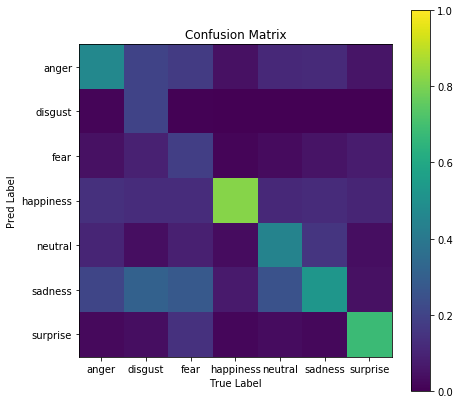

In [43]:
fig, ax = plt.subplots(1,1)  
fig.set_figwidth(7)
fig.set_figheight(7)
img = ax.imshow(confusion, vmin=0, vmax=1)
ax.set_xticklabels([0, ]+list(axis))
ax.set_yticklabels([0, ]+list(axis))
ax.set_xlabel("True Label")
ax.set_ylabel("Pred Label")
ax.set_title("Confusion Matrix")
fig.colorbar(img)
plt.show()

In [44]:
model.save_weights(f's3://cellingt-ml-final-project/models/CNN_FER_baseline_dropout_epoch{epochs}_{int(time.time())}.ckpt')

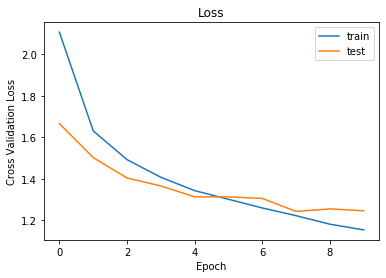

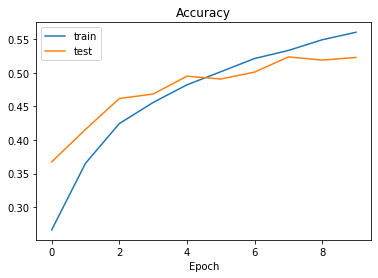

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Validation Loss")
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [57]:
dataset = np.load(fs.open('s3://cellingt-ml-final-project/data/FER_plus/FER_plus.npz'))
xtrain, xtest, xvalid, ytrain, ytest, yvalid, labels = dataset['xtrain'], dataset['xtest'], dataset['xvalid'], dataset['ytrain'], dataset['ytest'], dataset['yvalid'], dataset['labels']
ylabels = {i:label for i, label in enumerate(labels)}

xtrain = xtrain[:,:,:,np.newaxis]
xtest = xtest[:,:,:,np.newaxis]
xvalid = xvalid[:,:,:,np.newaxis]

In [76]:
# Build default TF2 CNN
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(labels), activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
epochs = 10
# model.load_weights('s3://cellingt-ml-final-project/models/CNN_FERplus_baseline_dropout_epoch10_1607367112.ckpt')
history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xtest, ytest))
# model.save_weights(f's3://cellingt-ml-final-project/models/CNN_FERplus_baseline_dropout_epoch{epochs}_{int(time.time())}.ckpt')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)         

In [59]:
# Confusion matrix calculation
yvalid_pred = model.predict(xvalid.astype(float))
yvalid_pred.shape

(3589, 10)

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral',
 7: 'contempt',
 8: 'unknown',
 9: 'NF'}

In [63]:
yvalid_label = np.array([ylabels[np.argmax(yval)] for yval in yvalid])
yvalid_pred_label = np.array([ylabels[np.argmax(yval)] for yval in yvalid_pred])
axis = np.unique(yvalid_label)
confusion = np.zeros((axis.shape[0], axis.shape[0]))
for i, li in enumerate(axis):
    for j, lj in enumerate(axis):
        truth_idx = yvalid_label == li
        pred_arr = yvalid_pred_label[truth_idx]
        confusion[j][i] = np.sum((pred_arr == lj).astype(int)) / len(pred_arr)

In [65]:
axis

array(['NF', 'anger', 'contempt', 'disgust', 'fear', 'happiness',
       'neutral', 'sadness', 'surprise', 'unknown'], dtype='<U9')

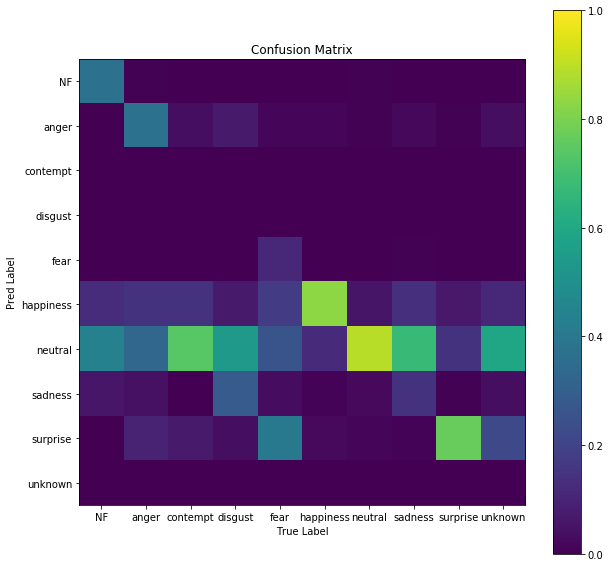

In [75]:
fig, ax = plt.subplots(1,1)  
fig.set_figwidth(10)
fig.set_figheight(10)
img = ax.imshow(confusion, vmin=0, vmax=1)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(axis))
ax.set_yticklabels(list(axis))
ax.set_xlabel("True Label")
ax.set_ylabel("Pred Label")
ax.set_title("Confusion Matrix")
fig.colorbar(img)
plt.show()

In [ ]:
history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xtest, ytest))
model.save_weights(f's3://cellingt-ml-final-project/models/CNN_FERplus_baseline_dropout_epoch{20}_{int(time.time())}.ckpt')

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 67s 2ms/sample - loss: 1.2067 - accuracy: 0.6993 - val_loss: 1.1830 - val_accuracy: 0.7010
Epoch 2/10
28709/28709 [==============================] - 65s 2ms/sample - loss: 1.1904 - accuracy: 0.7050 - val_loss: 1.1888 - val_accuracy: 0.6879
Epoch 3/10
28709/28709 [==============================] - 67s 2ms/sample - loss: 1.1757 - accuracy: 0.7117 - val_loss: 1.1714 - val_accuracy: 0.7038
Epoch 4/10
28709/28709 [==============================] - 65s 2ms/sample - loss: 1.1670 - accuracy: 0.7195 - val_loss: 1.1723 - val_accuracy: 0.7099
Epoch 5/10
28709/28709 [==============================] - 65s 2ms/sample - loss: 1.1611 - accuracy: 0.7193 - val_loss: 1.1869 - val_accuracy: 0.6916
Epoch 6/10
28709/28709 [==============================] - 67s 2ms/sample - loss: 1.1520 - accuracy: 0.7250 - val_loss: 1.1735 - val_accuracy: 0.6980
Epoch 7/10
28709/28709 [==============================] -

In [46]:
dataset = np.load(fs.open('s3://cellingt-ml-final-project/data/FER_processed/FER_edge.npz'))
xtrain, xtest, ytrain, ytest, labels = dataset['xtrain'], dataset['xtest'], dataset['ytrain'], dataset['ytest'], dataset['labels']
ylabels = {i:label for i, label in enumerate(labels)}

xtrain = xtrain[:,:,:,np.newaxis]
xtest = xtest[:,:,:,np.newaxis]

In [47]:
# Build default TF2 CNN
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(labels), activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
epochs = 10
history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xtest, ytest))
model.save_weights(f's3://cellingt-ml-final-project/models/CNN_FERedge_baseline_dropout_epoch{epochs}_{int(time.time())}.ckpt')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 64)         